In [5]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
from functools import partial
from scipy.special import erfcinv

In [6]:
import lib

In [35]:
class Simulation_angle():
    def __init__(self, neuron: lib.Neuron, xs_gen: lib.Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.refresh_every = max(refresh_every, n_tested_patterns)
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, self.refresh_every)
        self.w0 = None
        self.x0 = None
        self.init_w(subkey2)

        self.angle_record = np.zeros((neuron.nd, decay_steps))

    @partial(jax.jit, static_argnums=(0, ))
    def neuron_update_fun(self, w, x, latent_var):
        return self.neuron.update_fun(w, x, latent_var)

    def init_w(self, key):
        for i  in range(self.initial_steps):
            if i%self.refresh_every == 0:
                subkey, key = jax.random.split(key)
                xs0 = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self.neuron_update_fun(self.neuron.w, xs0[i%self.refresh_every], self.neuron.latent_var)
        self.w0 = self.neuron.w
        self.x0 = xs0[-1]

    @partial(jax.jit, static_argnums=(0, ))
    def _update_and_get_angles(self, w, latent_var, x):
        angles = jnp.sum(w*self.w0, axis=-1) # dim = (nd, )
        angles = angles/jnp.linalg.norm(self.w0, ord=2, axis=-1) # dim = (nd, )
        w, latent_var = self.neuron_update_fun(w, x, latent_var)
        return w, latent_var, angles

    def run(self, progress_bar=True):        
        # x0s = self.xs[:self.n_test_patterns] # in jax numpy, a copy is created for x0s
        if progress_bar is True: 
            pb = tqdm(range(self.decay_steps))
        else:
            pb = range(self.decay_steps)
        for i in pb:
            if i%self.refresh_every == 0 and i>=self.refresh_every:
                self.key, subkey = jax.random.split(self.key)
                self.xs = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var, angles = self._update_and_get_angles(self.neuron.w, self.neuron.latent_var, self.xs[i%self.refresh_every])
            self.angle_record[..., i] = angles

In [36]:
ns=300
nd=200
rho=1
bias = 2.75
ndR = 3
kappa = 1.5
n_votes = nd
vote_th = bias
la = bias - np.sqrt(2)*erfcinv(2*ndR/nd)
beta = 5.929289748543939

decay_steps = 10000
n_tested_patterns = 500
initial_steps = 10000

seed = 789456
rng = np.random.default_rng(seed)

neuron = lib.Neuron10_2_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, vote_th=vote_th, seed=rng.integers(100000))
# neuron = lib.Neuron3_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))
# neuron = lib.Neuron4_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, la=la, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))

# xs_gen = lib.Xs_Generator1(1, ns, normalized_len=np.sqrt(ns), seed=rng.integers(100000))
xs_gen = lib.Xs_Generator3_2(nd, ns, rho, normalized_len=np.sqrt(ns), seed=rng.integers(100000))

# simulation_run = lib.Simulation_Run(neuron, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))
simulation_run = Simulation_angle(neuron, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))

In [37]:
simulation_run.run()

100%|██████████| 10000/10000 [00:26<00:00, 374.48it/s]


In [38]:
ns=300
nd=200
rho=1
bias = 2.75
ndR = 3
kappa = 1.5
n_votes = nd
vote_th = bias
la = bias - np.sqrt(2)*erfcinv(2*ndR/nd)
beta = 5.929289748543939

decay_steps = 10000
n_tested_patterns = 500
initial_steps = 5000

seed = 789456
rng = np.random.default_rng(seed)

# neuron = lib.Neuron10_2_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, vote_th=vote_th, seed=rng.integers(100000))
neuron2 = lib.Neuron3_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))
# neuron = lib.Neuron4_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, la=la, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))

# xs_gen = lib.Xs_Generator1(1, ns, normalized_len=np.sqrt(ns), seed=rng.integers(100000))
xs_gen = lib.Xs_Generator3_2(nd, ns, rho, normalized_len=np.sqrt(ns), seed=rng.integers(100000))

# simulation_run = lib.Simulation_Run(neuron, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))
simulation_run2 = Simulation_angle(neuron2, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))

In [39]:
simulation_run2.run()

100%|██████████| 10000/10000 [00:27<00:00, 357.62it/s]


(0.0, 10000.0)

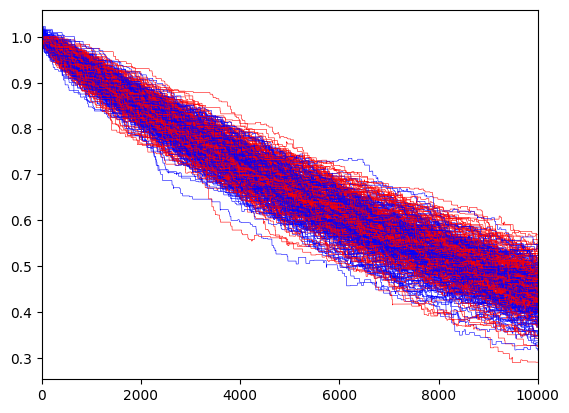

In [40]:
for i in range(nd):
    plt.plot(simulation_run.angle_record[i, :], c="blue", linewidth=0.4)
    plt.plot(simulation_run2.angle_record[i, :], c="red", linewidth=0.4)

plt.xlim(0, 10000)

In [41]:
np.linalg.norm(simulation_run.w0, axis=-1)

array([1.009721  , 1.0133399 , 0.9944077 , 1.0021892 , 0.9837271 ,
       0.98466355, 0.9969207 , 0.9951568 , 1.0122734 , 1.0093533 ,
       1.0202904 , 0.9916909 , 1.0082551 , 0.99623585, 0.99819696,
       0.99528635, 1.0229894 , 0.9908627 , 0.99413055, 0.99949694,
       0.9996109 , 0.9941075 , 0.9886457 , 0.9957126 , 1.003108  ,
       1.0148582 , 0.9988201 , 0.99536353, 0.9947961 , 1.0005773 ,
       1.0081121 , 1.0141398 , 0.98750997, 0.9990154 , 0.99806625,
       0.9790369 , 1.0024099 , 0.9968453 , 1.0052748 , 1.0126282 ,
       1.0123223 , 1.0152795 , 1.0014349 , 1.013365  , 0.97880965,
       0.9932866 , 1.0021393 , 1.0032642 , 0.99239296, 1.0128845 ,
       0.9928026 , 1.0051733 , 1.0089177 , 0.9946088 , 1.0045967 ,
       1.0085711 , 1.0107027 , 0.98946065, 0.9908512 , 0.9810141 ,
       1.0059352 , 1.011943  , 0.9915485 , 1.0068009 , 0.99872744,
       0.99645424, 0.9986097 , 0.9846798 , 0.9785749 , 1.0029662 ,
       1.0079675 , 0.9965506 , 1.0168335 , 0.96947724, 1.00888

In [42]:
np.linalg.norm(neuron.w, axis=-1)

array([1.004665  , 1.0022144 , 1.011261  , 0.9924294 , 1.0119127 ,
       0.97798896, 1.0141548 , 0.9977462 , 1.0049622 , 0.9898254 ,
       0.9847259 , 1.0069562 , 0.9891882 , 0.9844015 , 0.98513836,
       1.0124588 , 0.99624217, 1.0053468 , 0.98988837, 0.9847406 ,
       0.9956954 , 0.9897986 , 1.0044099 , 0.9858289 , 0.98113114,
       1.0012121 , 0.9871996 , 0.99519205, 1.0051996 , 1.015242  ,
       1.0061861 , 0.9835742 , 1.0122678 , 1.0080745 , 1.0047988 ,
       1.0000507 , 1.0042161 , 0.98362595, 1.0056115 , 0.99904484,
       0.99281794, 0.9939109 , 1.0098156 , 0.9799273 , 1.0011873 ,
       1.001556  , 1.000332  , 1.0016046 , 0.99710125, 0.9911161 ,
       0.99101955, 0.9827458 , 0.98743606, 0.99818176, 0.99690276,
       0.99316925, 0.98816174, 1.0065703 , 1.0032578 , 1.0058337 ,
       1.0027118 , 0.99560475, 0.99788636, 0.9827079 , 1.0037365 ,
       0.9758034 , 1.0083108 , 1.009728  , 0.9988107 , 1.003371  ,
       0.9867942 , 1.0012668 , 0.9998061 , 0.9995426 , 1.00249